In [7]:
import numpy as np
from utilities.Dataset import *
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List



In [11]:
from torcheeg.models import EEGNet
import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

        classifier= LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)
    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        model= EEGNet_IE_HP_Wrapper(
            DEVICE, classifier, input_dim
        ).to(DEVICE)

#         train_func= eeg_grad_train
#         model.training_procedure(iteration=n_epochs,
#                                  train_dataloader=train_dataloader,
#                                  val_dataloader=val_dataloader,
#                                  print_cycle=2,
#                                  path=f"./dictionary/intermdiate_dicts",
#                                  loss_func=criterion,
#                                  optimiser=optimizer, #scheduler=scheduler,
#                                  train_func=train_func
#                                 )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_Multivariate-e{EPOCH}.pt"
#                )
#         )
#         pickle.dump(model.return_IE_grad(),
#                     open(
#                         os.path.join(
#                             saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_Multivariate-grad_all-e{EPOCH}.pkl"
#                         ), "wb")
#         )
    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_Multivariate-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )
        model.IE_grad= pickle.load(
                open(
                    os.path.join(
                        saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_Multivariate-grad_all-e{n_epochs}.pkl"
                    ),"rb"
                )
            )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
    #     participants_grads_dictionary[participants[i]]= model.return_IE_grad()
        participants_dictionary.append(dictionary)
    pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet-Grad_Multivariate.pkl","wb"))
   

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


106 21

c0_acc 0.954954954954955 , c1_acc 0.42 , b_acc 0.6874774774774774
104 13

c0_acc 0.9043478260869565 , c1_acc 0.24528301886792453 , b_acc 0.5748154224774406
114 6

c0_acc 0.926829268292683 , c1_acc 0.11320754716981132 , b_acc 0.5200184077312472
121 12

c0_acc 0.9236641221374046 , c1_acc 0.21428571428571427 , b_acc 0.5689749182115594
114 10

c0_acc 0.9743589743589743 , c1_acc 0.20408163265306123 , b_acc 0.5892203035060177
120 3

c0_acc 0.96 , c1_acc 0.06 , b_acc 0.51
114 14

c0_acc 0.912 , c1_acc 0.25 , b_acc 0.581
121 7

c0_acc 0.9603174603174603 , c1_acc 0.11864406779661017 , b_acc 0.5394807640570353
128 15

c0_acc 0.9624060150375939 , c1_acc 0.2727272727272727 , b_acc 0.6175666438824333
126 9

c0_acc 0.9767441860465116 , c1_acc 0.15254237288135594 , b_acc 0.5646432794639338
111 7

c0_acc 0.9327731092436975 , c1_acc 0.14583333333333334 , b_acc 0.5393032212885154
116 29

c0_acc 0.9508196721311475 , c1_acc 0.5370370370370371 , b_acc 0.7439283545840922
119 15

c0_acc 0.96747967479

     accuracy  f1-score
S01  0.832298  0.817255
S02  0.702381  0.613095
S03  0.693182  0.633870
S04  0.700535  0.656939
S05  0.698795  0.631429
S06  0.714286  0.623421
S07  0.718232  0.687213
S08  0.675676  0.603360
S09  0.744681  0.706016
S10  0.755319  0.720046
S11  0.712575  0.657751
S12  0.818182  0.802445
S13  0.698324  0.655351
S14  0.679558  0.612646
S15  0.710383  0.634917
S16  0.699454  0.617884
S17  0.728916  0.683996
S19  0.663043  0.591489
S20  0.744444  0.710218


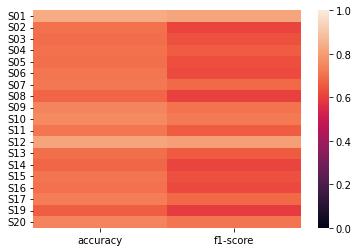

     class0 f1-score  class1 f1-score
S01         0.888889         0.658228
S02         0.818841         0.166667
S03         0.808511         0.228571
S04         0.809524         0.300000
S05         0.814815         0.193548
S06         0.829932         0.107143
S07         0.815884         0.400000
S08         0.797297         0.189189
S09         0.838926         0.384615
S10         0.842466         0.452381
S11         0.822222         0.250000
S12         0.879699         0.627907
S13         0.805755         0.325000
S14         0.800000         0.194444
S15         0.822742         0.208955
S16         0.817276         0.153846
S17         0.828897         0.347826
S19         0.789116         0.162162
S20         0.835714         0.425000


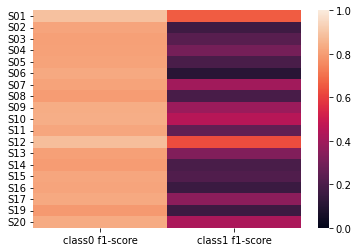

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [24]:
participant_grad={"AUC":[],"ROC":[],"STD":[]}
for i in range(len(participants)):
    g= pickle.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_Multivariate-grad_all-e{n_epochs}.pkl"
                ),"rb"
            )
    )
    
    participant_grad["AUC"].append(
        pd.DataFrame(
            Grad_AUC_with_multivar_grad(
                g, n_epochs, np.zeros(input_dim), x_shape=0, scaling=True
            )
        ).to_numpy()
    )
    participant_grad["ROC"].append(
          pd.DataFrame(
            Grad_ROC_with_multivar_grad(
                g, n_epochs, np.zeros(input_dim), x_shape=0, scaling=True
                                       )
          ).to_numpy()
    )
    participant_grad["STD"].append(
        pd.DataFrame(
            Grad_STD_with_multivar_grad(
                g, n_epochs, np.zeros(input_dim), x_shape=0, scaling=True
                                       )
        ).to_numpy()
    )
    
avg_grad={
    "AUC":np.array(participant_grad["AUC"]).mean(0),
    "ROC":np.array(participant_grad["ROC"]).mean(0),
    "STD":np.array(participant_grad["STD"]).mean(0)
}

In [25]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [26]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

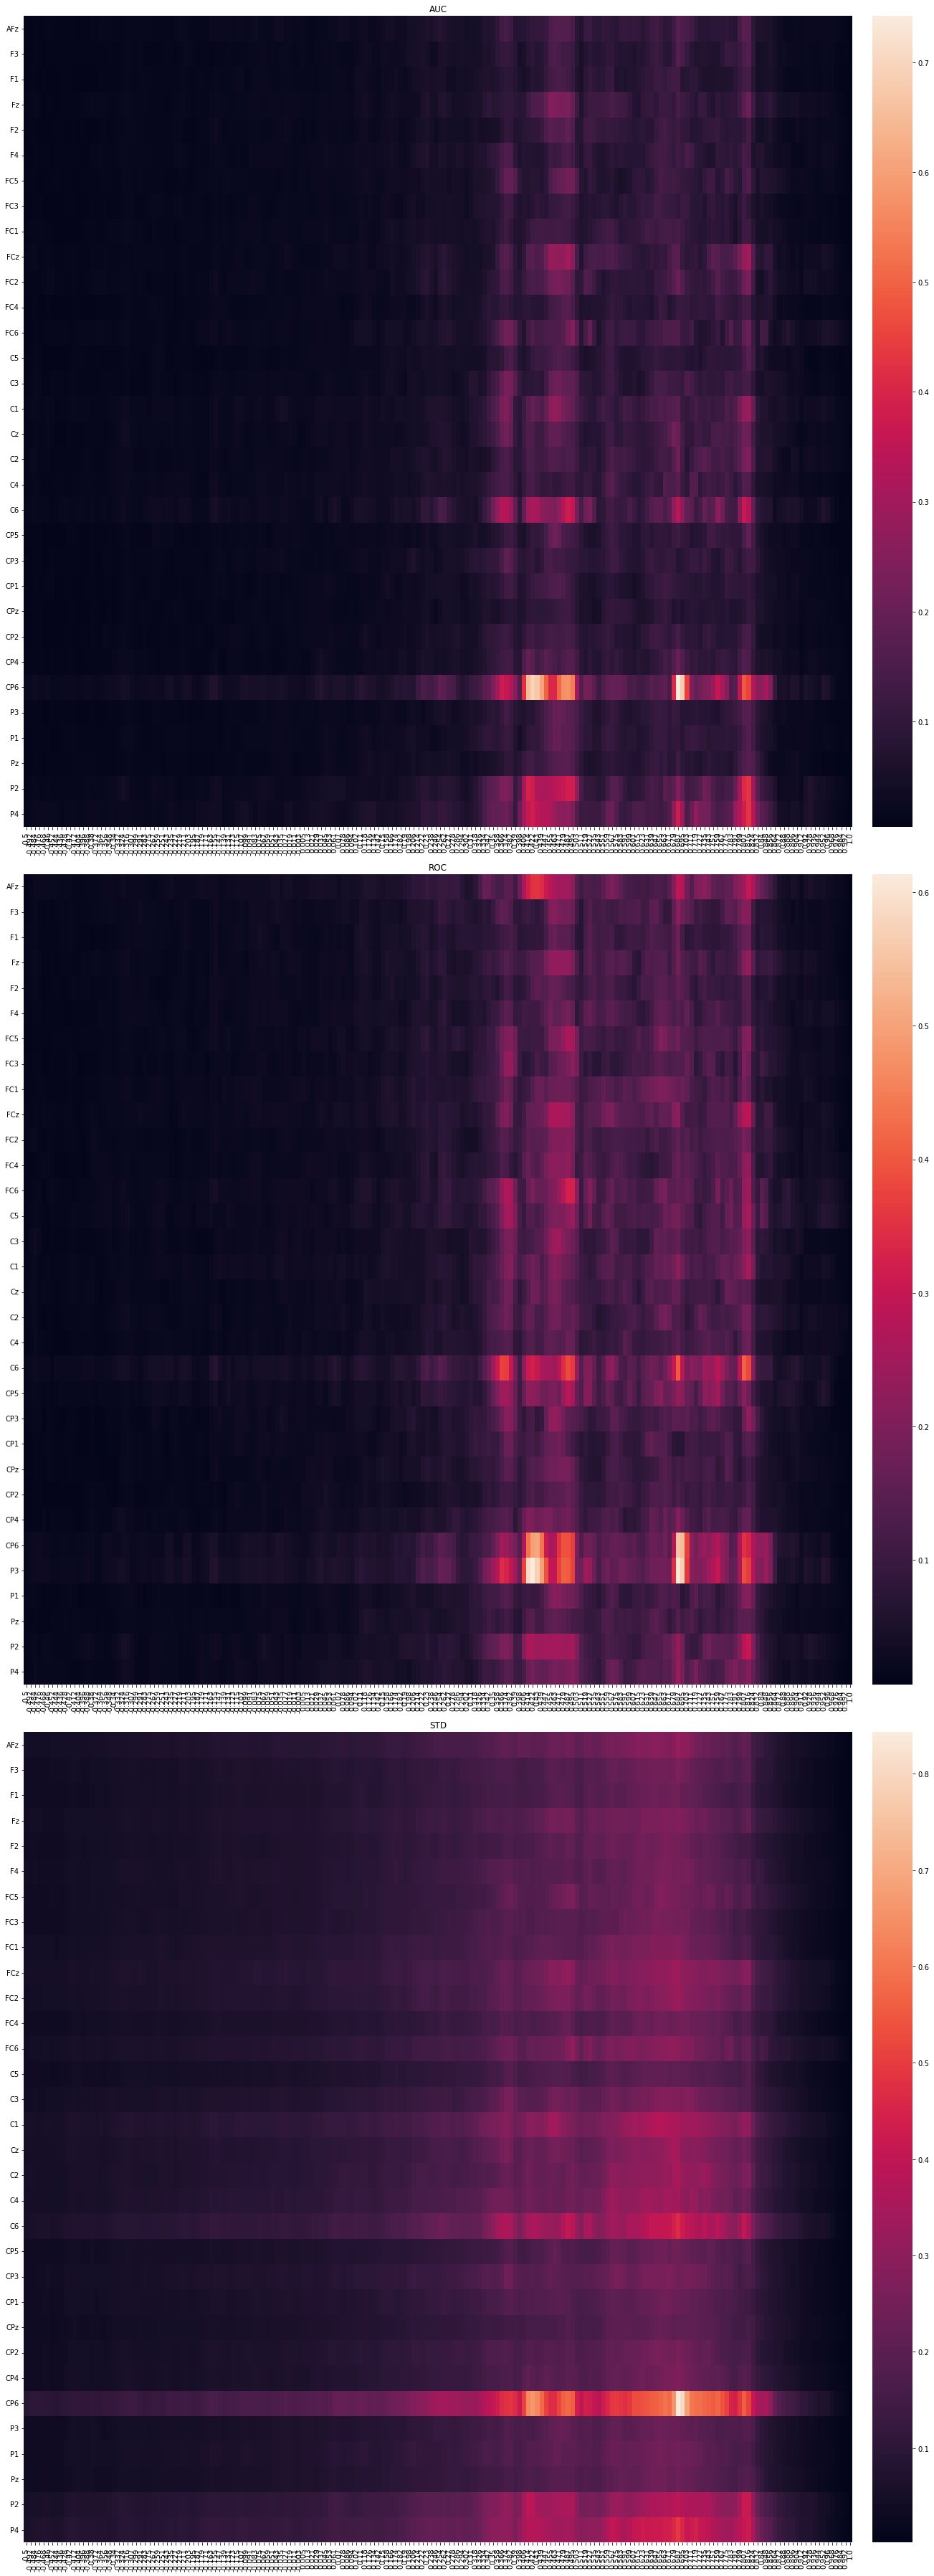

In [11]:
fig, ax= plt.subplots(3,1)

sns.heatmap(pd.DataFrame(avg_grad["AUC"]), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, ax=ax[0],
            annot=False, cbar_kws={"pad":0.02})

ax[0].set_title("AUC")

sns.heatmap(pd.DataFrame(avg_grad["ROC"]), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, ax=ax[1],
            annot=False, cbar_kws={"pad":0.02})
ax[1].set_title("ROC")

sns.heatmap(pd.DataFrame(avg_grad["STD"]), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, ax=ax[2],
            annot=False, cbar_kws={"pad":0.02})
ax[2].set_title("STD")

# plt.suptitle("Relative Importance Estimate of Time Series")
fig.set_figwidth(20)
fig.set_figheight(50)
plt.tight_layout()

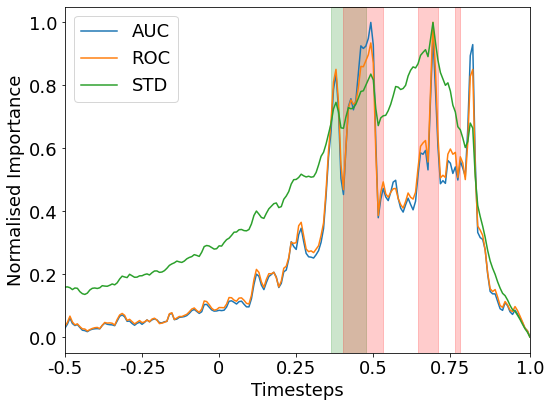

In [27]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
plt.figure(figsize=(8,6))
methods=["AUC", "ROC", "STD"]
for i in methods:
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(0).reshape(-1,1))
    df= pd.DataFrame(scaled_avg_grad)    

    plt.plot(scaled_avg_grad)
plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()


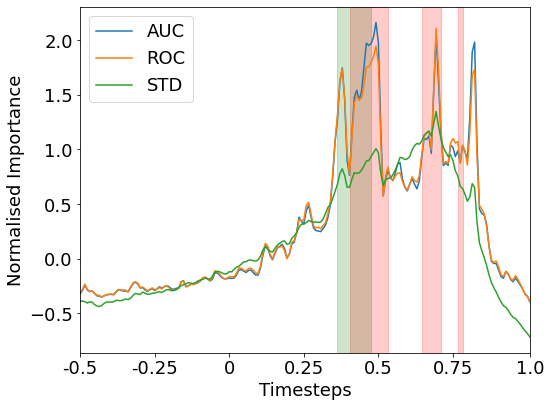

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
plt.figure(figsize=(8,6))
methods=["AUC", "ROC", "STD"]
for i in methods:
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(0).reshape(-1,1))
    df= pd.DataFrame(scaled_avg_grad)    

    plt.plot(scaled_avg_grad)
plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()


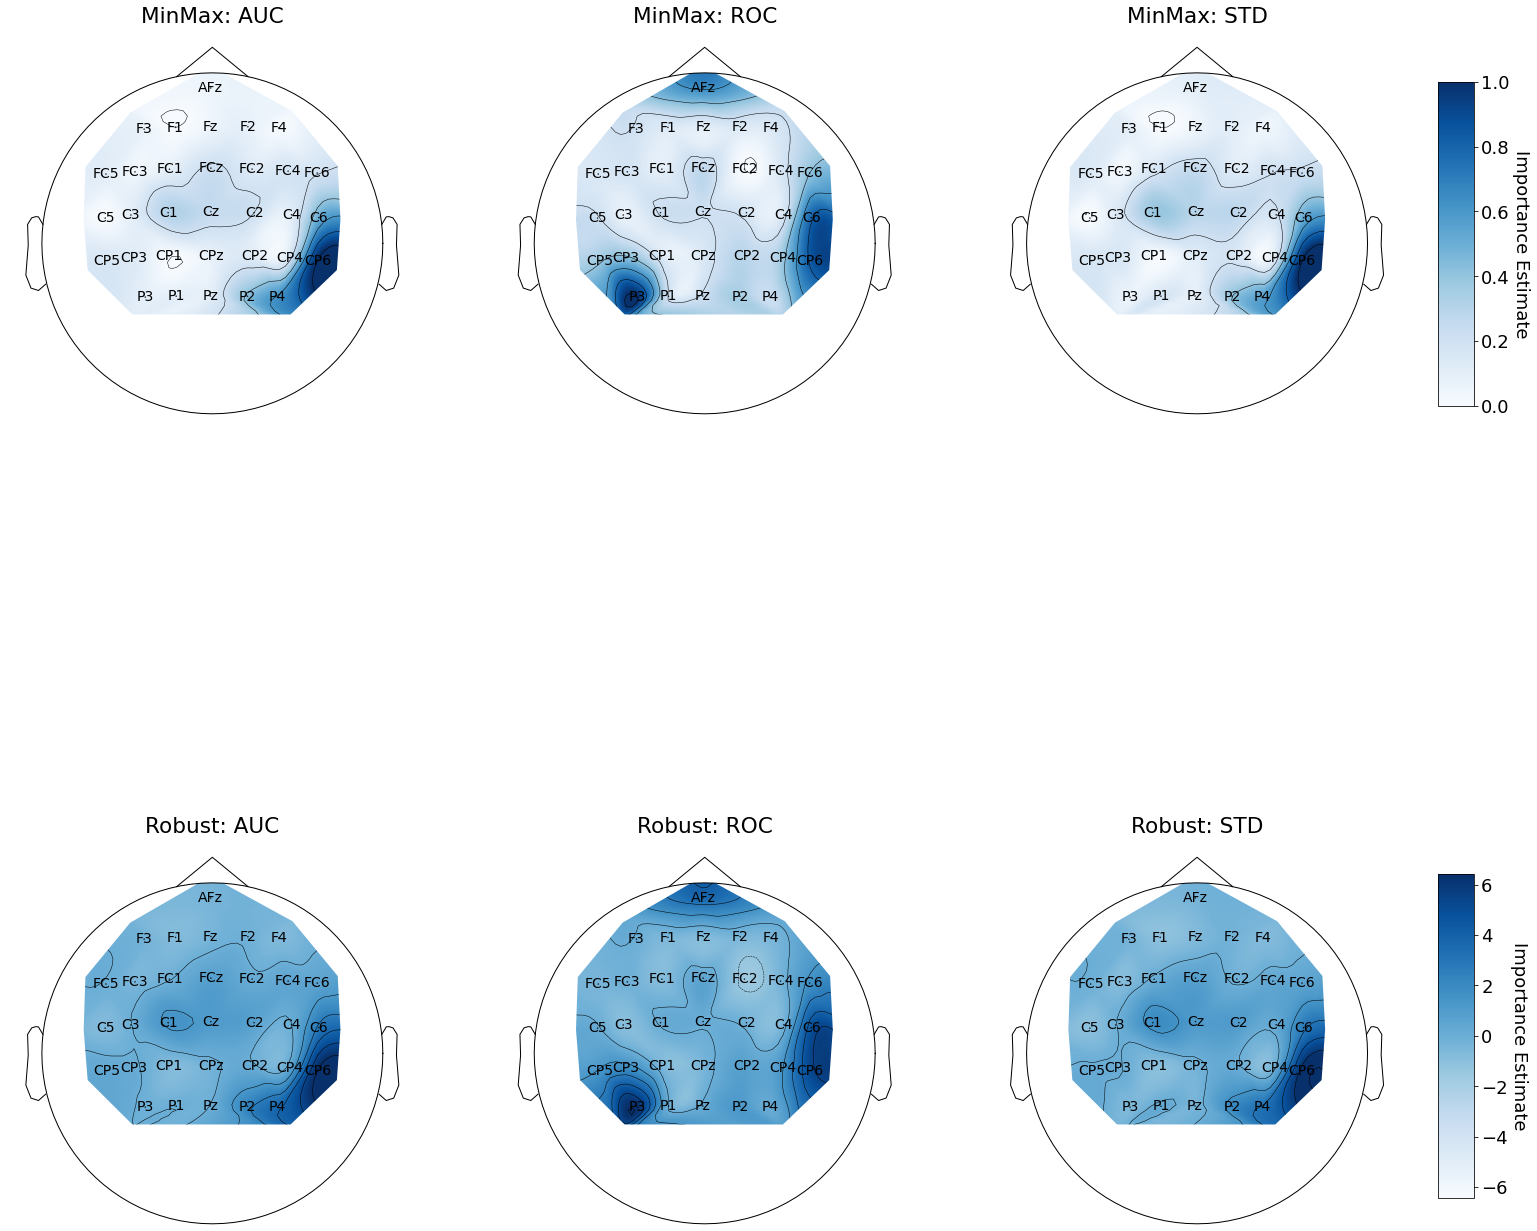

In [29]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig, ax= plt.subplots(2,3)
# ax= plt.axes((0,0,1.5,1.5))
for idx, i in enumerate(methods):
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(1).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    minmax_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[0][idx],
        show=False,
        extrapolate="local"
        #,vlim=(0,1)
    #     sphere=0.09
    )
    ax[0][idx].set_title(f"MinMax: {i}")
    
for idx, i in enumerate(methods):
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(1).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    robust_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[1][idx],
        show=False,
        extrapolate="local",
#         vlim=(0,None)
    #     sphere=0.09
    )
    ax[1][idx].set_title(f"Robust: {i}")
    
fig.set_figheight(25)
fig.set_figwidth(25)
# fig.add_axes(ax)
cbar_ax= fig.add_axes([.92,0.66, 0.02,0.18])
clb= fig.colorbar(minmax_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

cbar_ax= fig.add_axes([.92,0.22, 0.02,0.18])
clb= fig.colorbar(robust_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)
# plt.tight_layout()